# Customer Lifetime Value Analysis

---------------

### [Reading pkl and Loading Packages](#intro)
   - Reading pkl
   - Loading packages

### [Data Preparation](#prep)
   - Creating frequency, recency, age summary
   
### [Frequency/Recency Analysis w the BG/NBD model](#bg/nbd)
- Analyzing customers
- Predicting probabilities of customer returns

### [Assessing Model Fit](#fit)
- Comparing predictions with hold-out model

### [Customer predictions](#pred)
- probability of customer buying in period x
- probability of customer being alive

### [Estimating average transaction value](#exp)

### [CLV calculation using DCF](#clv)



----------------


<a id='intro'></a>
Reading in data & loading packages

In [2]:
%matplotlib inline
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [3]:
df = pd.read_pickle('/Users/lukas/Desktop/CapstoneLukas/NOSO/USJH_order_dataset_orderUnit.pkl')

In [4]:
df.head()

,Name,Financial Status,Paid at,Fulfillment Status,Accepts Marketing,Currency,Subtotal,Shipping,Taxes,Total,...,Note Attributes,Cancelled at,Payment Method,Refunded Amount,Vendor,Tags,Risk Level,Source,Color,item_quantity
0,#1001,paid,2015-11-05 17:17:00,fulfilled,no,USD,33.25,10.00,1.55,44.80,...,None,None,Cash on Delivery (COD),0.00,USJewelryhouse,None,Low,web,Tassel,7
1,#1002,refunded,2015-11-03 16:22:00,fulfilled,no,USD,7.65,6.89,0.00,14.54,...,None,None,Shopify Payments,14.54,USJewelryhouse,None,Low,web,Black,3
2,#1003,paid,2015-11-03 16:31:00,fulfilled,no,USD,6.37,6.89,0.00,13.26,...,None,None,PayPal Express Checkout,0.00,USJewelryhouse,None,Low,web,Black,1
3,#1004,paid,2015-11-06 16:51:00,fulfilled,yes,USD,50.00,7.61,0.00,57.61,...,None,None,Shopify Payments,0.00,USJewelryhouse,None,Low,web,Torso,2
4,#1005,paid,2015-11-09 15:02:00,fulfilled,yes,USD,11.50,6.89,0.00,18.39,...,None,None,Cash on Delivery (COD),0.00,USJewelryhouse,None,Low,web,Black,2


In [5]:
df.columns

Index(['Name', 'Financial Status', 'Paid at', 'Fulfillment Status',
       'Accepts Marketing', 'Currency', 'Subtotal', 'Shipping', 'Taxes',
       'Total', 'Discount Code', 'Discount Amount', 'Shipping Method',
       'Created at', 'Lineitem fulfillment status', 'Shipping Street',
       'Shipping Address1', 'Shipping Address2', 'Shipping Company',
       'Shipping City', 'Shipping Zip', 'Shipping Province',
       'Shipping Country', 'Notes', 'Note Attributes', 'Cancelled at',
       'Payment Method', 'Refunded Amount', 'Vendor', 'Tags', 'Risk Level',
       'Source', 'Color ', 'item_quantity'],
      dtype='object')

In [6]:
#taking shipping street as customer id 
df2 = df[['Created at', 'Shipping Street']]

In [7]:
df2.head()

,Created at,Shipping Street
0,2015-10-27 16:16:00,"1239 Broadway, FLR1"
1,2015-11-03 16:22:00,"1239 Broadway, FLR1"
2,2015-11-03 16:31:00,"1239 Broadway, FLR1"
3,2015-11-06 16:51:00,"2800 Monticello Place, 23- 302"
4,2015-11-06 18:09:00,"1239 Broadway, FLR1"


### Data Preparation
<a id='prep'></a>



In [8]:
from lifetimes.utils import summary_data_from_transaction_data

In [9]:
summary = summary_data_from_transaction_data(df2, 'Shipping Street', 'Created at', observation_period_end='2018-07-16', freq= 'M')

In [10]:
summary.head()

,frequency,recency,T
Shipping Street,,,
105 Arbor Park Drive,3.0,23.0,23.0
1428 212 street,0.0,0.0,11.0
"1 Abbott Road, Unit 68",0.0,0.0,29.0
1 David N Meyers Parkway,0.0,0.0,22.0
1 Depot Pl,0.0,0.0,19.0


**Explanation**:

- *Frequency*: Number of repeat purchases (Total no. of purchases -1)
- *T*: Age of customer (I specified the time unit to be 'M' for months)
- *Recency*: Age of customer when they made their last purchase (0 if one-time customer)

## Frequency/Recency Analysis w the BG/NBD model
<a id='bg/nbd'></a>



In [11]:
from lifetimes import BetaGeoFitter

In [12]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 1564 subjects, a: 1.15, alpha: 2.96, b: 5.05, r: 0.29>


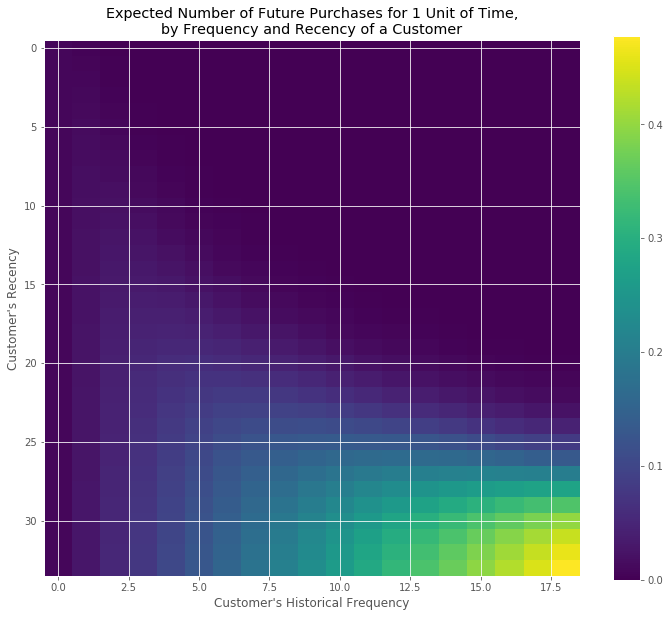

In [13]:
#plotting expected number of future purchases given frequency vs. recency
from lifetimes.plotting import plot_frequency_recency_matrix

plt.figure(figsize=(12,10))
plot_frequency_recency_matrix(bgf)

**What does this plot show?**

-> If a customer has bought ~18 times from USJH and their and their age at the latest purchase was slightly above 30, they are USJH's best customer

-> Fading tail shows that for customers that have bough around 5 times from USJH and their recency was between 20 and 25, they still might buy again but they also might be dead



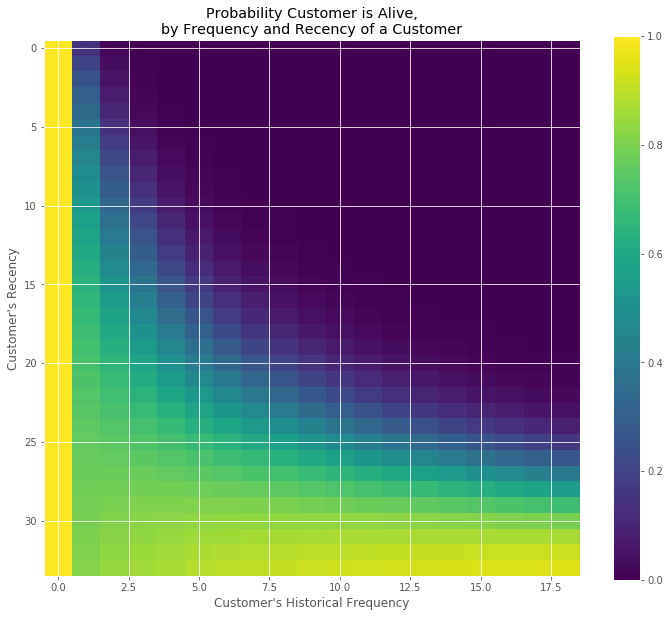

In [14]:
#plotting probability that customer is still alive given frequency vs. recency
from lifetimes.plotting import plot_probability_alive_matrix

plt.figure(figsize=(12,10))
plot_probability_alive_matrix(bgf)

In [15]:
#ranking customers from best to worst given their probability of buying in the next month
t = 1
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary.sort_values(by='predicted_purchases').tail()

,frequency,recency,T,predicted_purchases
Shipping Street,,,,
722 Southwest Westwood Drive,5.0,6.0,6.0,0.506001
"1924 8th St NW, 115",4.0,4.0,4.0,0.517735
26 Lark Industrial Parkway,10.0,12.0,13.0,0.542625
2026 Chestnut Street,10.0,12.0,13.0,0.542625
3904 Hwy 22,12.0,14.0,15.0,0.584133


-> Customer w address 3904 Hwy 22 has the highest probability of purchasing next month

## Assessing model fit
<a id='fit'></a>



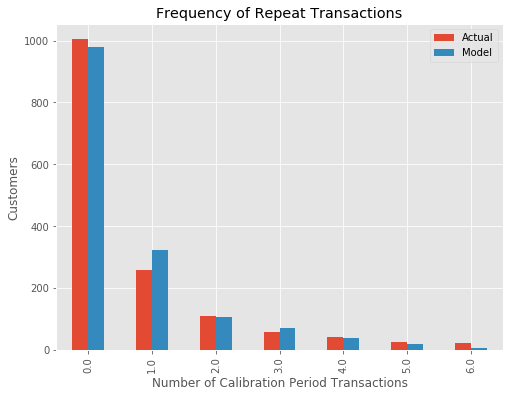

In [16]:
#comparing our data with artificially simulated data  with our fitted model’s parameters
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf, figsize=(8,6))

-> model seems to be relevant

## Dividing into calibration and holdout data set

In [17]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(df2, 'Shipping Street', 'Created at',
                                        calibration_period_end='2018-01-31',
                                        observation_period_end='2018-07-16', 
                                                   freq='M'
                                                  )   
print(summary_cal_holdout.head())

                          frequency_cal  recency_cal  T_cal  \
Shipping Street                                               
 105 Arbor Park Drive               1.0         13.0   17.0   
 1428 212 street                    0.0          0.0    5.0   
1 Abbott Road, Unit 68              0.0          0.0   23.0   
1 David N Meyers Parkway            0.0          0.0   16.0   
1 Depot Pl                          0.0          0.0   13.0   

                          frequency_holdout  duration_holdout  
Shipping Street                                                
 105 Arbor Park Drive                   2.0                 6  
 1428 212 street                        0.0                 6  
1 Abbott Road, Unit 68                  0.0                 6  
1 David N Meyers Parkway                0.0                 6  
1 Depot Pl                              0.0                 6  


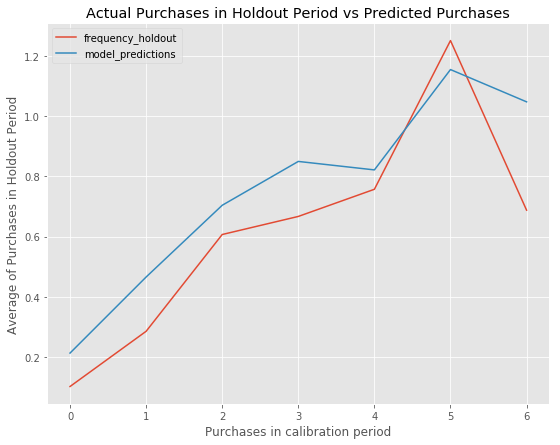

In [18]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, figsize=(9,7))

## Predicting Probability of specific customer buying in X periods
<a id='intro'></a>

In [19]:
summary2 = summary
summary2['id'] = summary2.index

In [20]:
summary2.head()

,frequency,recency,T,predicted_purchases,id
Shipping Street,,,,,
105 Arbor Park Drive,3.0,23.0,23.0,0.107881,105 Arbor Park Drive
1428 212 street,0.0,0.0,11.0,0.020719,1428 212 street
"1 Abbott Road, Unit 68",0.0,0.0,29.0,0.009092,"1 Abbott Road, Unit 68"
1 David N Meyers Parkway,0.0,0.0,22.0,0.011630,1 David N Meyers Parkway
1 Depot Pl,0.0,0.0,19.0,0.013211,1 Depot Pl


In [21]:
#defining a function that returns the probability of customer x buying in n peridos
def customer_order_prob(periods=1, index=0):

    summary2 = summary
    summary2['id'] = summary2.index
    
    t = index 
    individual = summary2.iloc[periods]
    individual_id = summary2.iloc[index].id
    probability = bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])
    return('The customer residing at ' + individual_id + ' will return over the course of ' + str(periods) + ' periods with a probability of {:.2f}'.format(probability))

In [22]:
#sample request
customer_order_prob(4, 2)

'The customer residing at 1 Abbott Road, Unit 68 will return over the course of 4 periods with a probability of 0.03'

## Plot predicting probability of customer x being alive

In [27]:
df2.iloc[2]

Created at         2015-11-03 16:31:00
Shipping Street    1239 Broadway, FLR1
Name: 2, dtype: object

In [28]:
def alive_plotter(address, min_months_alive=5):   
    from lifetimes.plotting import plot_history_alive

  # summary2 = summary
  #  summary2['id'] = summary2.index

  #  individual_id = summary2.iloc[index].id
    
    months_since_birth = 5
    sp_trans = df2.loc[df2['Shipping Street'] == address]
    plt.figure(figsize=(12,10))
    plot_history_alive(bgf, months_since_birth, sp_trans, 'Created at')

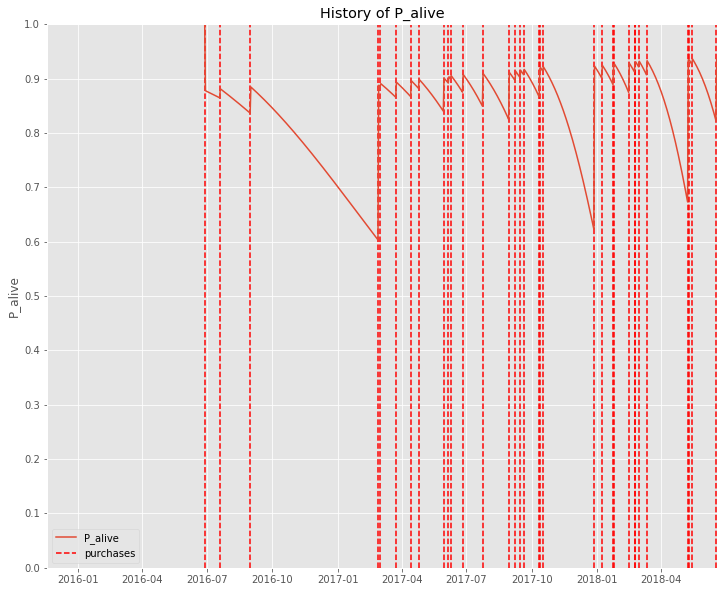

In [29]:
#address id equivalent here - put in any address/id to display graph
alive_plotter('1600 Division Road')

## Estimating CLV using Gamma-Gamma Model
<a id='exp'></a>

In [144]:
#creating a dataframe including the monetary value of each transaction
summary2 = summary_data_from_transaction_data(df, 'Shipping Street', 'Created at',monetary_value_col='Total', observation_period_end='2018-07-16', freq= 'M')

In [147]:
summary2.head()

,frequency,recency,T,monetary_value
Shipping Street,,,,
105 Arbor Park Drive,3.0,23.0,23.0,201.683333
1428 212 street,0.0,0.0,11.0,0.000000
"1 Abbott Road, Unit 68",0.0,0.0,29.0,0.000000
1 David N Meyers Parkway,0.0,0.0,22.0,0.000000
1 Depot Pl,0.0,0.0,19.0,0.000000


In [150]:
#filter summary to only include customers that have returned at least once
returning_customers_summary = summary2[summary2['frequency']>0]

returning_customers_summary.head()

,frequency,recency,T,monetary_value
Shipping Street,,,,
105 Arbor Park Drive,3.0,23.0,23.0,201.683333
"1 Lido Blvd , Apt 1C",4.0,8.0,9.0,384.547500
"1 Parker Ave, #1208",4.0,16.0,26.0,286.487500
1 barnes circle,1.0,5.0,20.0,109.580000
1 greenwood court,4.0,12.0,25.0,45.437500


In [153]:
#Gamma-Gamma model relies on assumption that monetary value and purchase frequency are independent
indep_test = returning_customers_summary[['monetary_value', 'frequency']]

In [154]:
#correlation
indep_test.corr()

,monetary_value,frequency
monetary_value,1.000000,0.066845
frequency,0.066845,1.000000


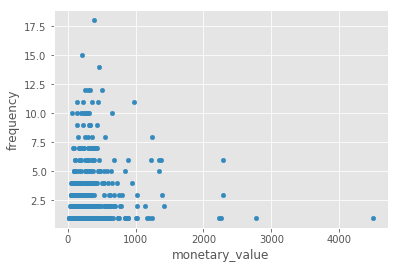

In [158]:
indep_test.plot(x='monetary_value', y='frequency', kind='scatter')

In [159]:
#fitting model
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 560 subjects, p: 2.16, q: 3.18, v: 324.87>


**Estimating average transaction value**

In [173]:
CoExAvPr = pd.DataFrame(ggf.conditional_expected_average_profit(
        summary2['frequency'],
        summary2['monetary_value']
    ))

In [174]:
CoExAvPr.columns = ['conditional_expected_average_profit']

In [176]:
CoExAvPr.sort_values(by='conditional_expected_average_profit', ascending=False).head(10)

,conditional_expected_average_profit
Shipping Street,
"5650 Greenpointe Drive N, Warehouse C",2403.029323
1239 Broadway,2004.865052
"Seminario 615, Providencia",1797.374884
99 Farmview DR C,1542.083939
559 Spring Road,1285.901600
143 corporate place,1274.122701
"777 NW 72ND AVE, STE 1001",1225.111293
825 Walnut St.,1193.929019
1285 Grandview Avenue,1169.956797


**Calculating total CLV using Discounted Cash Flow Method (DCF)**
<a id='clv'></a>

In [179]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary2['frequency'], summary2['recency'], summary2['T'])

clv = pd.DataFrame(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary2['frequency'],
    summary2['recency'],
    summary2['T'],
    summary2['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
))

In [181]:
clv.sort_values(by='clv', ascending=False).head(10)

,clv
Shipping Street,
3772 Main St,29421.847503
1908 Haven Bend,29189.790142
"Seminario 615, Providencia",27149.601081
10 High ridge Rd,25863.192473
825 Walnut St.,21582.937179
9810 3rd Ave,18230.579697
425 Dexter Street,17382.535295
720 asbury ave,17339.095575
1600 Division Road,16930.788319
